In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from collections import Counter
from underthesea import word_tokenize
import nltk
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (classification_report, accuracy_score, 
                            confusion_matrix, f1_score, precision_score, 
                            recall_score, ConfusionMatrixDisplay)
from sklearn.utils.class_weight import compute_class_weight

In [4]:
train = pd.read_json('archive/train-segment.json').T
test = pd.read_json('archive/test-segment.json').T

# train = pd.DataFrame(train)
# test = pd.DataFrame(test)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24046 entries, 0 to 24047
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  24046 non-null  object
 1   label    24046 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [6]:
train.head(20)

,comment,label
0,em được làm fan cứng luôn rồi nè ❤ r...,clean
1,đúng là bọn mắt híp lò xo thụt : ) ) )...,hate
2,đậu văn cường giờ giống thằng sida...,clean
3,côn đồ cục súc vô nhân tính đề nghi ...,hate
4,từ lý thuyết đến thực hành là cả 1...,clean
5,coronavirus is manmade,clean
6,đố chúng m nhận ra ai,clean
7,lúp lúp như chó .,offensive
8,🥰 🥰 🥰,clean
9,"thế mà mình nói mấy thằng bắc kì ,...",hate


In [7]:
train.shape

(24046, 2)

/tmp/ipykernel_22002/1637504323.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=train, palette='viridis', order=train['label'].value_counts().index)


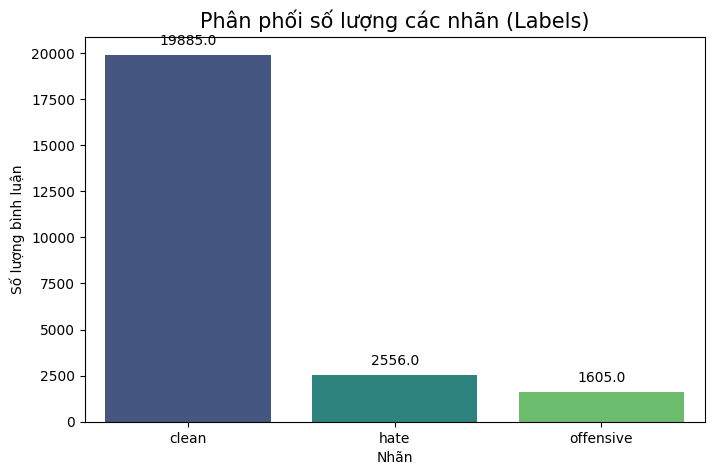

In [8]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=train, palette='viridis', order=train['label'].value_counts().index)
plt.title('Phân phối số lượng các nhãn (Labels)', fontsize=15)
plt.xlabel('Nhãn')
plt.ylabel('Số lượng bình luận')

# Hiển thị số lượng trên cột
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

In [9]:
train['char_count'] = train['comment'].astype(str).apply(len)
train['word_count'] = train['comment'].astype(str).apply(lambda x: len(x.split()))

# Thống kê mô tả về độ dài từ
print("Thống kê số lượng từ trong bình luận:")
print(train.groupby('label')['word_count'].describe())

Thống kê số lượng từ trong bình luận:
             count       mean        std  min  25%   50%   75%     max
label                                                                 
clean      19885.0  12.162736  48.526914  1.0  5.0   9.0  14.0  4906.0
hate        2556.0  22.214397  19.482950  1.0  9.0  16.0  29.0   187.0
offensive   1605.0  12.197508  12.044711  1.0  5.0   9.0  15.0   102.0


# data processing

In [10]:
train_x = train['comment']
test_x = test['comment']

train_y = train['label']
test_y = test['label']

### thống nhất bảng mã

In [11]:
import unicodedata

def normalize_unicode(text):
    return unicodedata.normalize('NFC', text)

train_x = train_x.apply(normalize_unicode)
test_x = test_x.apply(normalize_unicode)

### xử lý teencode(viết tắt)

In [12]:
def normalize_teencode(text):
    teencode_dict = {
    "ko": "không", "k": "không", "kh": "không", "hok": "không", "hk": "không",
    "dc": "được", "đc": "được", "dk": "được", "đk": "được",
    "t": "tao", "m": "mày", "mn": "mọi người", "ng": "người", "mik": "mình",
    "r": "rồi", "rui": "rồi",
    "v": "vậy", "z": "vậy",
    "vs": "với",
    "j": "gì",
    "h": "giờ", "bh": "bây giờ",
    "ngta": "người ta",
    "ak": "à", "ah": "à",
    "iu": "yêu",
    "ib": "nhắn tin",
    "thui": "thôi",
    "wa": "quá",
    "ik": "đi",
    "ck": "chồng", "vk": "vợ",
    "nx": "nữa",
    "nt": "nhắn tin",
    "kb": "kết bạn",
    "thik": "thích",
    "nek": "nè",
    "cj": "chị", "chj": "chị",
    "bit": "biết", "bik": "biết",
    "lun": "luôn",
    "vl": "vãi", "vcl": "vãi cả lồn", "vkl": "vãi cả lồn", "vc": "vãi cứt",
    "dell": "đéo",
    "cmn": "con mẹ nó", "cmnr": "con mẹ nó rồi",
    "loz": "lồn", "lz": "lồn",
    "đm" : "địt mẹ", "dm" : "địt mẹ"
    }
    words = text.split()
    normalized_words = [teencode_dict.get(word.lower(), word) for word in words]
    return " ".join(normalized_words)

In [13]:
train_x = train_x.apply(normalize_teencode)
test_x = test_x.apply(normalize_teencode)

In [14]:
train_x.head(20)

0     em được làm fan cứng luôn rồi nè ❤ reaction qu...
1     đúng là bọn mắt híp lò xo thụt : ) ) ) bên việ...
2              đậu văn cường giờ giống thằng sida hơn à
3     côn đồ cục súc vô nhân tính đề nghi vn . nhà n...
4     từ lý thuyết đến thực hành là cả 1 câu chuyện ...
5                                coronavirus is manmade
6                               đố chúng mày nhận ra ai
7                                     lúp lúp như chó .
8                                                 🥰 🥰 🥰
9     thế mà mình nói mấy thằng bắc kì , bọn đó lại ...
10       được anh ưi , lâu rồi không nghe phúc du rap 🤣
11                   cắt cho trẻ trâu bớt thôi mà 😂 😂 😂
12              nghe rất vô lí nhưng cực kì thuyết phục
13           chán ghê hong có pé 2 mới máu được , hâhha
14                                 sao tao gửi được bây
15    thế đấy . làm gì bọn nó . bọn nó có quyền nên ...
16             loại này cho dựa cột thôi chứ độ thế nào
17                                        thuong

### Thay thế các ký tự lặp lại hơn 2 lần thành 1 lần (vd: đẹppp -> đẹp)

In [15]:
def remove_duplicate_characters(text):
    return re.sub(r'(.)\1+', r'\1', text)

train_x = train_x.apply(remove_duplicate_characters)


In [16]:
train_x.head()

0    em được làm fan cứng luôn rồi nè ❤ reaction qu...
1    đúng là bọn mắt híp lò xo thụt : ) ) ) bên việ...
2             đậu văn cường giờ giống thằng sida hơn à
3    côn đồ cục súc vô nhân tính đề nghi vn . nhà n...
4    từ lý thuyết đến thực hành là cả 1 câu chuyện ...
Name: comment, dtype: object

### xử lý emoji


In [17]:
import re

def normalize_emoticons(text):
    # 1. Xử lý các loại cười: :), :)), : ) ), =)), = ) )
    # Giải thích regex:
    # [:=]       : Bắt đầu bằng dấu : hoặc dấu =
    # \s* : Có thể có khoảng trắng hoặc không
    # (?:\)\s*)+ : Nhóm dấu đóng ngoặc ) lặp lại ít nhất 1 lần, xen kẽ khoảng trắng
    text = re.sub(r'[:=]\s*(?:\)\s*)+', '😂', text)

    # 2. Xử lý mặt buồn: :(, :((, : ( (
    text = re.sub(r'[:=]\s*(?:\(\s*)+', '😢', text)

    # 3. Xử lý kiểu cười pacman: :v, : v
    text = re.sub(r':\s*v', '😄', text, flags=re.IGNORECASE)

    # 6. Xử lý kiểu >.< hoặc -_- (tùy chọn)
    text = re.sub(r'-\s*-', '😐', text)

    return text


In [18]:
train_x = train_x.apply(normalize_emoticons)
test_x = test_x.apply(normalize_emoticons)

In [19]:
train_x.head(38)

0     em được làm fan cứng luôn rồi nè ❤ reaction qu...
1     đúng là bọn mắt híp lò xo thụt 😂bên việt nam t...
2              đậu văn cường giờ giống thằng sida hơn à
3     côn đồ cục súc vô nhân tính đề nghi vn . nhà n...
4     từ lý thuyết đến thực hành là cả 1 câu chuyện ...
5                                coronavirus is manmade
6                               đố chúng mày nhận ra ai
7                                     lúp lúp như chó .
8                                                 🥰 🥰 🥰
9     thế mà mình nói mấy thằng bắc kì , bọn đó lại ...
10       được anh ưi , lâu rồi không nghe phúc du rap 🤣
11                   cắt cho trẻ trâu bớt thôi mà 😂 😂 😂
12              nghe rất vô lí nhưng cực kì thuyết phục
13            chán ghê hong có pé 2 mới máu được , hâha
14                                 sao tao gửi được bây
15    thế đấy . làm gì bọn nó . bọn nó có quyền nên ...
16             loại này cho dựa cột thôi chứ độ thế nào
17                                        thuong

## Tokenization

In [20]:
def tokenizer(text):
    # Check if text is already a list (already tokenized)
    if isinstance(text, list):
        return text
    
    # Ensure input is string
    text = str(text) if text is not None else ""
    
    tokens = word_tokenize(text)
    return tokens

train_x = train_x.apply(tokenizer)
test_x = test_x.apply(tokenizer)

In [21]:
train_x.head(10)

0    [em, được, làm, fan, cứng, luôn, rồi, nè, ❤ re...
1    [đúng, là, bọn, mắt, híp, lò xo, thụt, 😂, bên,...
2    [đậu, văn cường, giờ, giống, thằng, sida, hơn, à]
3    [côn đồ, cục, súc, vô nhân tính, đề nghi, vn, ...
4    [từ, lý thuyết, đến, thực hành, là, cả, 1, câu...
5                           [coronavirus, is, manmade]
6                        [đố, chúng mày, nhận, ra, ai]
7                              [lúp, lúp, như, chó, .]
8                                            [🥰, 🥰, 🥰]
9    [thế, mà, mình, nói, mấy, thằng, bắc kì, ,, bọ...
Name: comment, dtype: object

## loại bỏ stopword



In [22]:
stopwords_vn = set([
    'thì', 'là', 'mà', 'và', 'của', 'những', 'cái', 'này', 'được', 'có', 'cho', 'với',
    'không', 'như', 'các', 'em', 'anh', 'mình', 'bạn', 'người', 'thấy', 'đã', 'đang'
])

def remove_stopwords(lst):
    return [word for word in lst if word.lower() not in stopwords_vn]



In [23]:
train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)

In [24]:
# ==================== DATA AUGMENTATION ====================
# Ensure train_x and test_x are strings before augmentation/vectorization
if isinstance(train_x.iloc[0], list):
    train_x = train_x.apply(lambda x: ' '.join(x))
    test_x = test_x.apply(lambda x: ' '.join(x))

print("Train_x shape:", train_x.shape)
print("Test_x shape:", test_x.shape)

def synonym_replacement(text, n=2):
    "Thay thế từ đồng nghĩa (đơn giản)"
    words = text.split()
    if len(words) < 3:
        return text
    synonym_dict = {
        'xấu': ['tệ', 'dở'],
        'tốt': ['hay', 'đẹp'],
        'ghét': ['căm', 'không thích'],
        'thích': ['yêu', 'mê'],
        'ngu': ['ngốc', 'dốt'],
        'thông minh': ['khôn', 'lanh'],
    }
    new_words = words.copy()
    try:
        random_indices = np.random.choice(len(words), min(n, len(words)), replace=False)
        for idx in random_indices:
            word = words[idx]
            if word in synonym_dict:
                new_words[idx] = np.random.choice(synonym_dict[word])
    except ValueError:
        pass
    return " ".join(new_words)




def augment_text(text):
    "Áp dụng ngẫu nhiên 1 phương pháp augmentation"
    method = synonym_replacement
    return method(text)

# Prepare for augmentation
label_counts = train_y.value_counts()
print("Original label distribution:")
print(label_counts)

minority_labels = ['hate', 'offensive']
augmented_texts = []
augmented_labels = []

print("Augmenting data...")
temp_df = pd.DataFrame({'comment': train_x, 'label': train_y})

for label in minority_labels:
    label_data = temp_df[temp_df['label'] == label]
    current_count = len(label_data)
    target_count = int(current_count * 1.3)
    aug_count = target_count - current_count
    
    print(f"Augmenting '{label}': +{aug_count} samples")
    
    if aug_count > 0:
        samples = label_data.sample(n=aug_count, replace=True)
        for text in samples['comment']:
            aug_text = augment_text(text)
            augmented_texts.append(aug_text)
            augmented_labels.append(label)

if augmented_texts:
    aug_x = pd.Series(augmented_texts)
    aug_y = pd.Series(augmented_labels)
    train_x_aug = pd.concat([train_x, aug_x], ignore_index=True)
    train_y_aug = pd.concat([train_y, aug_y], ignore_index=True)
    print("New train shape:", train_x_aug.shape)
    print("New label distribution:")
    print(train_y_aug.value_counts())
else:
    train_x_aug = train_x
    train_y_aug = train_y
    print("No augmentation performed.")


Train_x shape: (24046,)
Test_x shape: (6680,)
Original label distribution:
label
clean        19885
hate          2556
offensive     1605
Name: count, dtype: int64
Augmenting data...
Augmenting 'hate': +766 samples
Augmenting 'offensive': +481 samples
New train shape: (25293,)
New label distribution:
clean        19885
hate          3322
offensive     2086
Name: count, dtype: int64


In [25]:
def getWordCloud(words):

    # Combine all words into a single text string.
    text = ' '.join(words)
    # Generate a word cloud image.
    wordcloud = WordCloud().generate(text)
    # Display the generated image using matplotlib.
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    # Create a new word cloud with adjusted font size.
    wordcloud = WordCloud(max_font_size=40).generate(text)
    # Create a new figure and display the adjusted word cloud.
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    plt.show()

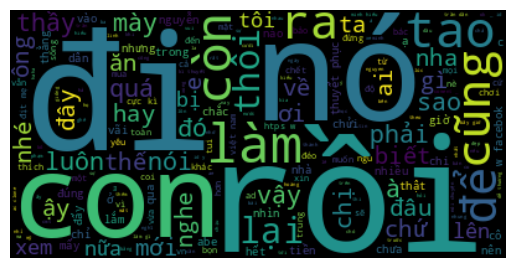

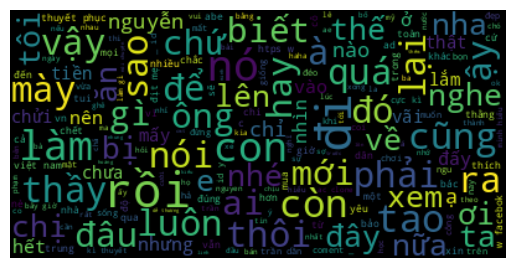

In [26]:
word_list = []

for senc in train_x:
    # Combine words in each sentence into a single string.
    if isinstance(senc, list):
        merged = ' '.join(senc)
    else:
        merged = senc
    word_list.append(merged)
# Generate and display a word cloud
getWordCloud(word_list)

In [27]:
Y = pd.concat([train_y, test_y]).reset_index(drop=True)

clean = []
hate = []
offensive = []

# Iterate through cleaned data and labels.
for data, label in zip(train_x, Y):
    # Categorize data based on label.
    if label == 'clean':
        clean.append(data)

    elif label == 'hate':
        hate.append(data)

    elif label == 'offensive':
        offensive.append(data)


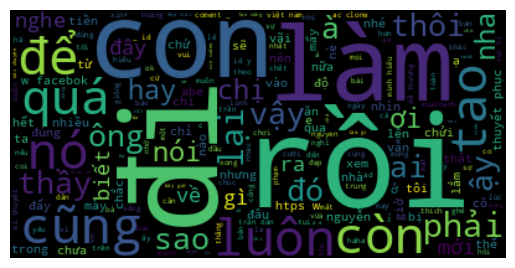

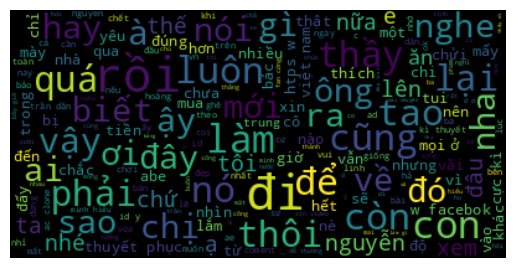

In [28]:
word_list = []

for senc in clean:
    if isinstance(senc, list):
        merged = ' '.join(senc)
    else:
        merged = senc
    word_list.append(merged)

getWordCloud(word_list)

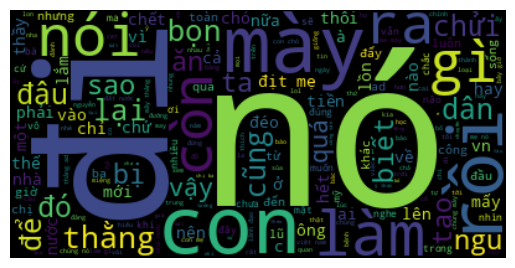

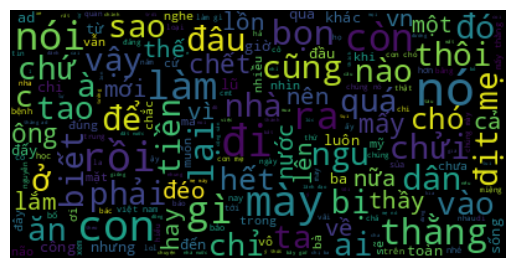

In [29]:
word_list = []

for senc in hate:
    if isinstance(senc, list):
        merged = ' '.join(senc)
    else:
        merged = senc
    word_list.append(merged)

getWordCloud(word_list)

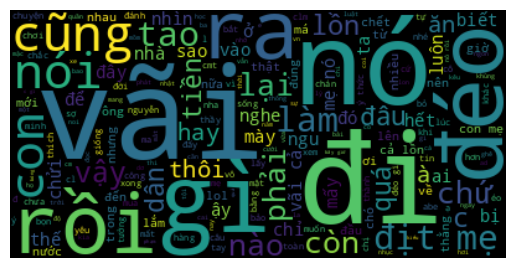

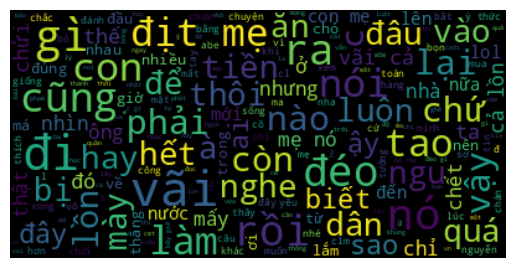

In [30]:
word_list = []

for senc in offensive:
    if isinstance(senc, list):
        merged = ' '.join(senc)
    else:
        merged = senc
    word_list.append(merged)

getWordCloud(word_list)

### label encoding

In [31]:
le_label = LabelEncoder()
train_y = le_label.fit_transform(train_y)
test_y = le_label.transform(test_y)

### TF_IDF

In [32]:
train_x_str = train_x.apply(lambda x: ' '.join(x))
test_x_str = test_x.apply(lambda x: ' '.join(x))

In [33]:
# Determine training data source (use augmented data if available)
if 'train_x_aug' in locals():
    print("Using augmented training data (train_x_aug).")
    train_data_source = train_x_aug
else:
    print("Using original training data (train_x).")
    train_data_source = train_x

# Ensure data is in string format (not list of tokens)
if isinstance(train_data_source.iloc[0], list):
    train_data_source = train_data_source.apply(lambda x: ' '.join(x))

test_data_source = test_x
if isinstance(test_data_source.iloc[0], list):
    test_data_source = test_data_source.apply(lambda x: ' '.join(x))

tfidf_vect = TfidfVectorizer(
    ngram_range=(1, 3), 
    min_df=2,
    max_df=0.8,
    sublinear_tf=True)

# Fit on train and transform both train and test
X_train_tfidf = tfidf_vect.fit_transform(train_data_source)
X_test_tfidf = tfidf_vect.transform(test_data_source)

print(f"Kích thước tập train sau TF-IDF: {X_train_tfidf.shape}")
print(f"Kích thước tập test sau TF-IDF: {X_test_tfidf.shape}")

print("Số lượng đặc trưng được trích xuất:")
print(len(tfidf_vect.vocabulary_))
print("100 đặc trưng đầu tiên:")
print(list(tfidf_vect.vocabulary_.keys())[:100])


Using augmented training data (train_x_aug).
Kích thước tập train sau TF-IDF: (25293, 63005)
Kích thước tập test sau TF-IDF: (6680, 63005)
Số lượng đặc trưng được trích xuất:
63005
100 đặc trưng đầu tiên:
['làm', 'fan', 'cứng', 'luôn', 'rồi', 'nè', 'reaction', 'quá', 'hay', 'cute', 'coi', 'mấy', 'giờ', 'hợp', 'lí', 'làm fan', 'fan cứng', 'cứng luôn', 'luôn rồi', 'rồi nè', 'nè reaction', 'reaction quá', 'quá hay', 'hay quá', 'quá cute', 'cute coi', 'coi mấy', 'mấy giờ', 'giờ quá', 'quá hợp', 'hợp lí', 'làm fan cứng', 'fan cứng luôn', 'cứng luôn rồi', 'luôn rồi nè', 'rồi nè reaction', 'nè reaction quá', 'reaction quá hay', 'quá hay quá', 'hay quá cute', 'quá cute coi', 'cute coi mấy', 'coi mấy giờ', 'mấy giờ quá', 'giờ quá hợp', 'quá hợp lí', 'đúng', 'bọn', 'mắt', 'híp', 'lò', 'xo', 'thụt', 'bên', 'việt', 'nam', 'tao', 'ra', 'cách', 'đây', '10', 'năm', 'gọi', 'là', 'đúng bọn', 'bọn mắt', 'mắt híp', 'híp lò', 'lò xo', 'xo thụt', 'thụt bên', 'bên việt', 'việt nam', 'nam tao', 'tao ra', 'ra

### huấn luyện mô hình

In [35]:
# ==================== 1. LOAD & PREPROCESS DEV DATA ====================
import pandas as pd
import numpy as np
from sklearn.model_selection import PredefinedSplit
from scipy.sparse import vstack

# Load dữ liệu (Giả định file tên là dev_segment.json tương tự train/test)
try:
    dev = pd.read_json('archive/dev-segment.json').T
    print("Loaded dev-segment.json successfully.")
except ValueError:
    print("Error: Không tìm thấy file 'dev-segment.json'. Hãy kiểm tra lại tên file.")

# Lấy dữ liệu Text và Label
dev_x = dev['comment']
dev_y_raw = dev['label']

# --- Áp dụng quy trình làm sạch (giống hệt tập Train) ---
# Lưu ý: Các hàm này phải đã được định nghĩa ở các bước trước trong notebook của bạn
dev_x = dev_x.apply(normalize_unicode)
dev_x = dev_x.apply(normalize_teencode)
dev_x = dev_x.apply(remove_duplicate_characters)
dev_x = dev_x.apply(normalize_emoticons)
dev_x = dev_x.apply(tokenizer)
dev_x = dev_x.apply(remove_stopwords)

# Chuyển về dạng chuỗi (nếu đang là list token)
if isinstance(dev_x.iloc[0], list):
    dev_x = dev_x.apply(lambda x: ' '.join(x))

# --- Vector hóa & Mã hóa nhãn ---
# QUAN TRỌNG: Chỉ dùng .transform(), KHÔNG dùng .fit_transform()
X_dev_tfidf = tfidf_vect.transform(dev_x)
y_dev_encoded = le_label.transform(dev_y_raw)

print(f"Dev Set Size: {X_dev_tfidf.shape}")

# ==================== 2. SETUP VALIDATION SPLIT ====================

# Xác định lại dữ liệu Train đang dùng (Xử lý trường hợp có Augmentation)
X_train_current = X_train_tfidf
if 'final_train_y_encoded' in locals():
    y_train_current = final_train_y_encoded
elif 'train_y_aug' in locals():
    y_train_current = train_y_aug 
else:
    y_train_current = train_y # Biến gốc nếu không có aug

# Gộp tập Train và Dev lại (Yêu cầu của Sklearn khi dùng PredefinedSplit)
X_combined = vstack([X_train_current, X_dev_tfidf])
y_combined = np.concatenate([y_train_current, y_dev_encoded])

# Tạo chỉ mục Split: -1 là Train (không validate), 0 là Validation (Dev)
# Điều này giúp GridSearch huấn luyện trên phần -1 và đánh giá trên phần 0
split_index = [-1] * X_train_current.shape[0] + [0] * X_dev_tfidf.shape[0]
ps = PredefinedSplit(test_fold=split_index)

print(f"Combined Data Size: {X_combined.shape}")
print("Ready for Training with Fixed Validation Set.")

Loaded dev-segment.json successfully.
Dev Set Size: (2672, 63005)
Combined Data Size: (27965, 63005)
Ready for Training with Fixed Validation Set.


In [ ]:
# ==================== DATA PREPARATION FOR SKLEARN ====================
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# 0. Ensure base labels variables exist
if 'train_y' not in locals() and 'train' in locals():
    train_y = train['label']
if 'test_y' not in locals() and 'test' in locals():
    test_y = test['label']

# 1. Select correct label source (augmented if available)
if 'train_y_aug' in locals():
    print("Using augmented labels (train_y_aug).")
    final_train_y = train_y_aug
else:
    print("Using original labels (train_y).")
    final_train_y = train_y

# Normalize to numpy array to avoid index issues
final_train_y = final_train_y.to_numpy() if isinstance(final_train_y, pd.Series) else final_train_y
test_y_input = test_y.to_numpy() if isinstance(test_y, pd.Series) else test_y

# 2. Label Encoding
le = LabelEncoder()
try:
    final_train_y_encoded = le.fit_transform(final_train_y)
    y_train = final_train_y_encoded # Update y_train for next steps
    
    # Handle potentially unseen labels in test set
    # Ideally test set shouldn't have labels not in train, but just in case.
    test_y_encoded = le.transform(test_y_input)
    y_test = test_y_encoded # Update y_test for next steps

    print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
    print(f"Training Data Shape: {final_train_y.shape}")

except Exception as e:
    print(f"Error during Label Encoding: {e}")
    print(f"Train Y sample: {final_train_y[:5]}")
    print(f"Test Y sample: {test_y_input[:5]}")


Using augmented labels (train_y_aug).
Error during Label Encoding: y contains previously unseen labels: 0
Train Y sample: ['clean' 'hate' 'clean' 'hate' 'clean']
Test Y sample: [0 2 0 0 2]


In [ ]:
# ==================== CLASS WEIGHTS ====================
classes = np.unique(train_y_aug)
class_weights = compute_class_weight('balanced', classes=classes, y=train_y_aug)
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)


Class weights: {'clean': 0.4239879306009555, 'hate': 2.53792895845876, 'offensive': 4.041706615532119}


In [ ]:
# ==================== IMPROVED BASELINE MODEL TRAINING ====================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC  # Import LinearSVC để chạy nhanh hơn
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time


X_train_base = X_train_tfidf if 'X_train_tfidf' in locals() else None
X_test_base = X_test_tfidf if 'X_test_tfidf' in locals() else None

if 'final_train_y_encoded' in locals():
    y_train_base = final_train_y_encoded
    y_test_base = test_y_encoded if 'test_y_encoded' in locals() else (test_y if 'test_y' in locals() else test['label'])
else:
    y_train_base = train_y_aug if 'train_y_aug' in locals() else train['label']
    y_test_base = test_y if 'test_y' in locals() else test['label']

# 3. Tính Class Weights (để xử lý mất cân bằng dữ liệu)
classes = np.unique(y_train_data)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_data)
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weight_dict)

# 4. Định nghĩa các mô hình Baseline (Nhanh & Nhẹ)
# Lưu ý: LinearSVC nhanh hơn rất nhiều so với SVC thông thường cho text classification
models = {
    'Naive Bayes': MultinomialNB(),
    
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        n_jobs=-1, 
        random_state=42
    ),
    
    'Linear SVM': LinearSVC(
        class_weight='balanced', 
        random_state=42, 
        dual='auto', # Tự động chọn thuật toán tối ưu
        max_iter=3000
    )
}

results = {}

print("\n" + "="*40)
print(" TRAINING BASELINE MODELS (FAST) ")
print("="*40)

for model_name, model in models.items():
    # print(f"\nTraining {model_name}...")
    start_time = time.time()
    
    # Huấn luyện
    model.fit(X_train_data, y_train_data)
    
    # Dự đoán
    pred = model.predict(X_test_data)
    
    # Đánh giá
    f1 = f1_score(y_test_data, pred, average='macro')
    acc = accuracy_score(y_test_data, pred)
    
    training_time = time.time() - start_time
    
    results[model_name] = {
        'model': model,
        'pred': pred,
        'f1_macro': f1,
        'accuracy': acc
    }
    
    print(f"Done in {training_time:.2f}s")
    print(f"F1 Macro: {f1:.4f} | Accuracy: {acc:.4f}")

# 5. In báo cáo chi tiết
print("\n" + "="*40)
print(" DETAILED EVALUATION ")
print("="*40)
for model_name, res in results.items():
    print(f"\n--- {model_name} ---")
    print(classification_report(y_test_data, res['pred'], digits=4))

Class Weights: {0: 0.4239879306009555, 1: 2.53792895845876, 2: 4.041706615532119}

 TRAINING BASELINE MODELS (FAST) 
Done in 0.01s
F1 Macro: 0.3392 | Accuracy: 0.8352
Done in 4.83s
F1 Macro: 0.6198 | Accuracy: 0.8280
Done in 0.62s
F1 Macro: 0.6160 | Accuracy: 0.8575

 DETAILED EVALUATION 

--- Naive Bayes ---
              precision    recall  f1-score   support

           0     0.8369    0.9989    0.9108      5548
           1     0.6226    0.0480    0.0891       688
           2     0.8000    0.0090    0.0178       444

    accuracy                         0.8352      6680
   macro avg     0.7532    0.3520    0.3392      6680
weighted avg     0.8124    0.8352    0.7668      6680


--- Logistic Regression ---
              precision    recall  f1-score   support

           0     0.9428    0.8798    0.9102      5548
           1     0.4565    0.6642    0.5411       688
           2     0.3845    0.4347    0.4080       444

    accuracy                         0.8280      6680
   macr

In [ ]:
# ==================== OPTIMIZED HYPERPARAMETER TUNING ====================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time

# 1. Map Data & Labels (Fix Variable Name Mismatches)
X_train_data = X_train_tfidf if 'X_train_tfidf' in locals() else None
X_test_data = X_test_tfidf if 'X_test_tfidf' in locals() else None

if 'final_train_y_encoded' in locals():
    y_train_data = final_train_y_encoded
    y_test_data = test_y_encoded if 'test_y_encoded' in locals() else (test_y if 'test_y' in locals() else test['label'])
else:
    # Fallback logic
    y_train_data = train_y_aug if 'train_y_aug' in locals() else train['label']
    y_test_data = test_y if 'test_y' in locals() else test['label']

# 2. Calculate Class Weights
# Ensure y_train_data is ready before this
classes = np.unique(y_train_data)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_data)
class_weight_dict = dict(zip(classes, class_weights))
print(f"Training Samples: {X_train_data.shape[0]}")
print(f"Class Weights: {class_weight_dict}")

results = {}

# 1. Logistic Regression
print(f"\n{'='*10} Tuning Logistic Regression {'='*10}")
start_time = time.time()

lr_params = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'] 
}

lr_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), 
    lr_params, 
    cv=ps, # Fixed cv=ps error
    scoring='f1_macro', 
    n_jobs=-1,
    verbose=1
)
lr_grid.fit(X_combined, y_combined)

print(f"Best LR Params: {lr_grid.best_params_}")
print(f"Time taken: {time.time() - start_time:.2f}s")

lr_best = lr_grid.best_estimator_
lr_pred = lr_best.predict(X_test_data)
results['Logistic Regression'] = {
    'model': lr_best,
    'pred': lr_pred,
    'f1_macro_test': f1_score(y_test_data, lr_pred, average='macro')
}

# 2. Linear SVM
print(f"\n{'='*10} Tuning Linear SVM {'='*10}")
start_time = time.time()

svm_params = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge']
}

svm_grid = GridSearchCV(
    LinearSVC(class_weight='balanced', random_state=42, max_iter=2000, dual='auto'),
    svm_params,
    cv=ps,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
svm_grid.fit(X_combined, y_combined)

print(f"Best SVM Params: {svm_grid.best_params_}")
print(f"Time taken: {time.time() - start_time:.2f}s")

svm_best = svm_grid.best_estimator_
svm_pred = svm_best.predict(X_test_data)
results['Linear SVM'] = {
    'model': svm_best,
    'pred': svm_pred,
    'f1_macro_test': f1_score(y_test_data, svm_pred, average='macro')
}

# 3. Naive Bayes
print(f"\n{'='*10} Tuning Naive Bayes {'='*10}")
start_time = time.time()

nb_params = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

nb_grid = GridSearchCV(
    MultinomialNB(), 
    nb_params, 
    cv=ps, 
    scoring='f1_macro', 
    n_jobs=-1,
    verbose=1
)
nb_grid.fit(X_combined, y_combined)

print(f"Best NB Params: {nb_grid.best_params_}")
print(f"Time taken: {time.time() - start_time:.2f}s")

nb_best = nb_grid.best_estimator_
nb_pred = nb_best.predict(X_test_data)
results['Naive Bayes'] = {
    'model': nb_best,
    'pred': nb_pred,
    'f1_macro_test': f1_score(y_test_data, nb_pred, average='macro')
}

# Summary
print("\n" + "="*40)
print(" TUNING RESULTS SUMMARY (Test Set) ")
print("="*40)
for name, res in results.items():
    print(f"{name:<20}: F1-Macro = {res['f1_macro_test']:.4f}")


Training Samples: 25293
Class Weights: {0: 0.4239879306009555, 1: 2.53792895845876, 2: 4.041706615532119}

========== Tuning Logistic Regression ==========
Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best LR Params: {'C': 10, 'solver': 'lbfgs'}
Time taken: 15.80s

========== Tuning Linear SVM ==========
Fitting 1 folds for each of 6 candidates, totalling 6 fits


c:\Users\Dell\anaconda3\envs\my_env\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best SVM Params: {'C': 1, 'loss': 'hinge'}
Time taken: 13.01s

========== Tuning Naive Bayes ==========
Fitting 1 folds for each of 12 candidates, totalling 12 fits
Best NB Params: {'alpha': 0.1, 'fit_prior': False}
Time taken: 0.25s

 TUNING RESULTS SUMMARY (Test Set) 
Logistic Regression : F1-Macro = 0.6289
Linear SVM          : F1-Macro = 0.6325
Naive Bayes         : F1-Macro = 0.5699



==================== Logistic Regression ====================
              precision    recall  f1-score   support

           0     0.9303    0.9165    0.9234      5548
           1     0.5098    0.5698    0.5381       688
           2     0.4247    0.4257    0.4252       444

    accuracy                         0.8482      6680
   macro avg     0.6216    0.6373    0.6289      6680
weighted avg     0.8534    0.8482    0.8506      6680



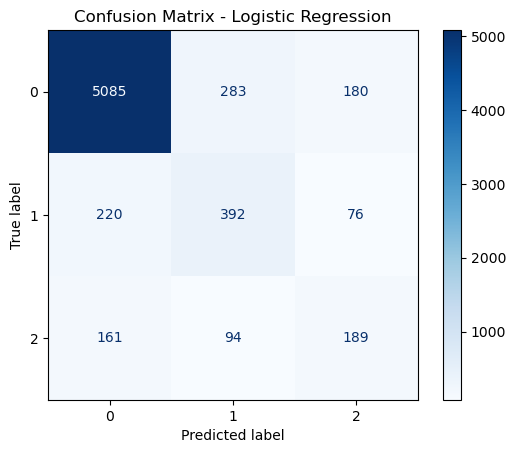


==================== Linear SVM ====================
              precision    recall  f1-score   support

           0     0.9270    0.9364    0.9317      5548
           1     0.5455    0.5581    0.5517       688
           2     0.4543    0.3806    0.4142       444

    accuracy                         0.8605      6680
   macro avg     0.6423    0.6250    0.6325      6680
weighted avg     0.8563    0.8605    0.8581      6680



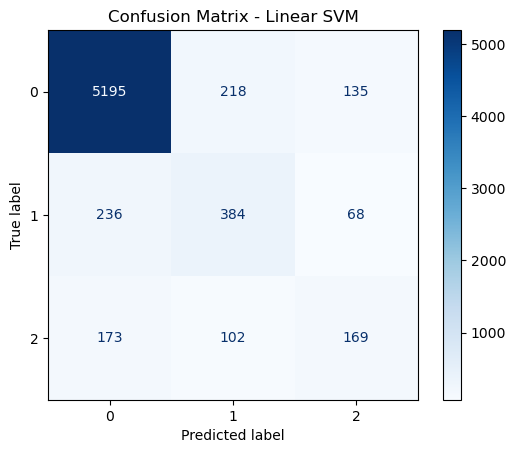


==================== Naive Bayes ====================
              precision    recall  f1-score   support

           0     0.9184    0.8928    0.9054      5548
           1     0.4130    0.5349    0.4661       688
           2     0.3586    0.3198    0.3381       444

    accuracy                         0.8178      6680
   macro avg     0.5633    0.5825    0.5699      6680
weighted avg     0.8292    0.8178    0.8225      6680



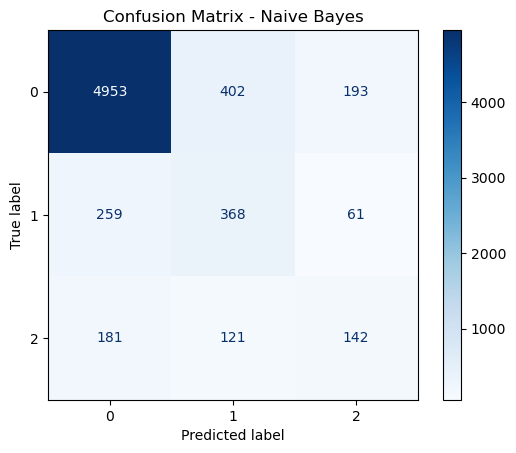

In [ ]:
# ==================== EVALUATION ====================
for model_name, res in results.items():
    print(f"\n{'='*20} {model_name} {'='*20}")
    print(classification_report(test_y, res['pred'], digits=4))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(test_y, res['pred'], labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
